#  Homework 4 - Berkeley STAT 157

**Name: Luyu Chen, SID 3034306110, teammates Zhiming Xu, Liang Huang, Zhaorui Zeng**

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import pandas as pd


import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 这只是为了一下显示100列，不会被折叠，忽略这段代码
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [3]:
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_train.csv')
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_test.csv')
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

## Data Preprocessing
### remove outlier

In [4]:
train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>200000)].index,inplace=True)
train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index,inplace=True)
train_data.drop(train_data[(train_data['YearBuilt']<1900) & (train_data['SalePrice']>400000)].index,inplace=True)
train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index,inplace=True)

In [5]:
print(train_data.shape)
print(test_data.shape)

(1456, 81)
(1459, 80)


### Analyze Correlation

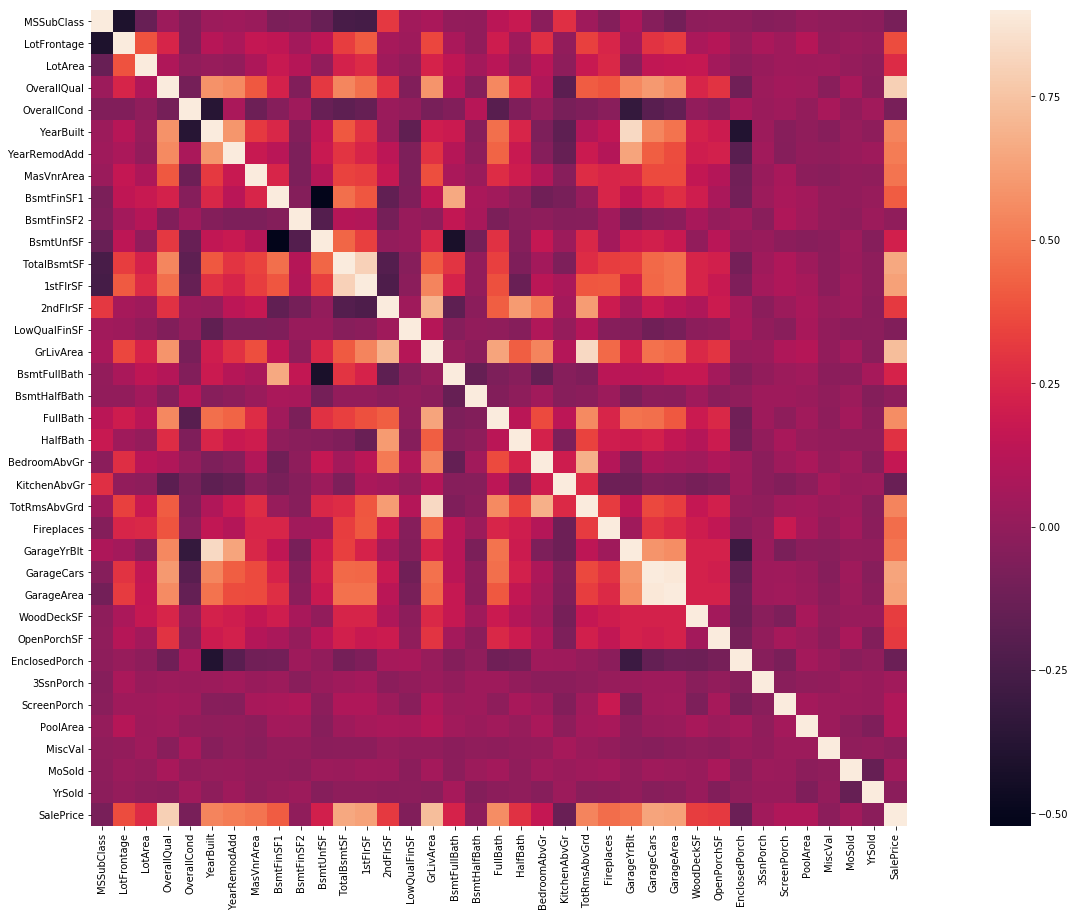

In [7]:
corrmat = train_data.iloc[:, 1:].corr()
plt.subplots(figsize=(30,15))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features = all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond'], axis=1)
all_features = all_features.drop(['LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'PoolArea'], axis=1)
all_features = all_features.reset_index(drop=True)
print(all_features.shape)
all_features.head(5)

(2915, 69)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,12,2008,WD,Normal


### Do something to years: add YearsSinceRemodel

In [9]:
all_features['YearsSinceRemodel'] = all_features['YrSold']- all_features['YearRemodAdd']
all_features = all_features.drop(['YrSold','MoSold','YearBuilt','YearRemodAdd'], 1)
print(all_features.shape)
all_features.head(5)

(2915, 66)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearsSinceRemodel
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,WD,Normal,5
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,WD,Normal,31
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,WD,Normal,6
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,WD,Abnorml,36
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,WD,Normal,8


### Missing value & Feature Selection

In [11]:
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
PoolQC,2906,0.996913
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,485,0.166381
GarageFinish,159,0.054545
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageType,157,0.053859


In [64]:
def fill_missings(res):
    #res['GarageType'] = res['GarageType'].fillna('missing')
    #res['GarageFinish'] = res['GarageFinish'].fillna('missing')
    #res['GarageQual'] = res['GarageQual'].fillna('missing')
    #res['GarageCond'] = res['GarageCond'].fillna('missing')
    
    #res['BsmtQual'] = res['BsmtQual'].fillna('missing')
    #res['BsmtCond'] = res['BsmtCond'].fillna('missing')
    #res['BsmtExposure'] = res['BsmtExposure'].fillna('missing')
    #res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    #res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    
    res['MSZoning'] = res['MSZoning'].fillna('missing')
    res['BsmtFullBath'] = res['BsmtFullBath'].fillna(res['BsmtFullBath'].mode()[0])
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])   
    res['BsmtFinSF1'] = res['BsmtFinSF1'].fillna(0)
    res['BsmtUnfSF'] = res['BsmtUnfSF'].fillna(res['BsmtUnfSF'].mode()[0])
    
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0]) 
    res["Functional"] = res["Functional"].fillna("Typ")
    res["Electrical"] = res["Electrical"].fillna(res["Electrical"].mode()[0])
    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    res['GarageArea'] = res['GarageArea'].fillna(0)
     
    #res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].fillna(0)
    res['MasVnrType'] = res['MasVnrType'].fillna('missing')
    


    return res

In [73]:
def map_values(full):
    
    full["oMSZoning"] = full.MSZoning.map({'missing': 0, 'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'missing':0, 'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    #full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'missing':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    #full["oBsmtExposure"] = full.BsmtExposure.map({'missing':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    
    #full["oGarageType"] = full.GarageType.map({'CarPort':1, 'missing':1,
                                           #'Detchd':2,
                                           #'2Types':3, 'Basment':3,
                                           #'Attchd':4, 'BuiltIn':5})
    
    #full["oGarageFinish"] = full.GarageFinish.map({'missing':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
    return "Done!"

In [14]:
def transform(X):

        #all_features = all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond', 'BsmtUnfSF', 'EnclosedPorch'], axis=1)
        #all_features = all_features.drop(['LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'PoolArea'], axis=1)
        X["TotalHouse"] =  X["1stFlrSF"] + X["2ndFlrSF"]   
        X["TotalArea"] =  X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
        X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
        X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
        X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
        X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
        X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
        X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
        
        X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
        X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
        X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
        X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
        X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
        X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]

        X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
        X["TotalPlace"] = X['BsmtUnfSF']+X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
        return X

In [15]:
all_features['LotArea'] = np.log1p(all_features['LotArea'] + 1.0)
all_features['3SsnPorch'] = np.log1p(all_features['3SsnPorch'] + 1.0)
all_features['KitchenAbvGr'] = np.log1p(all_features['KitchenAbvGr'] + 1.0)
all_features['EnclosedPorch'] = np.log1p(all_features['EnclosedPorch'] + 1.0)
all_features['ScreenPorch'] = np.log1p(all_features['ScreenPorch'] + 1.0)
all_features['MasVnrArea'] = np.log1p(all_features['MasVnrArea'] + 1.0)
all_features['OpenPorchSF'] = np.log1p(all_features['OpenPorchSF'] + 1.0)

### Normalize

In [16]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# after standardizing the data all means vanish, hence we can set missing values to 0
#all_features = all_features.fillna(0)
print(all_features.shape)
all_features.head(3)

(2915, 66)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearsSinceRemodel
0,0.067175,RL,-0.183043,-0.100176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.650801,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.209366,Gd,TA,PConc,Gd,TA,No,GLQ,0.601388,Unf,-0.933965,GasA,Ex,Y,SBrkr,-0.782389,1.212243,0.428891,1.089452,0.782974,1.233636,0.170104,-0.204059,Gd,Typ,-0.924299,NaN,Attchd,RFn,0.352944,TA,TA,Y,-0.739813,0.818682,-0.42641,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,-0.887840
1,-0.873119,RL,0.475068,0.151592,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.061051,Gable,CompShg,MetalSd,MetalSd,None,-0.793521,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.213886,Unf,-0.629175,GasA,Ex,Y,SBrkr,0.271541,-0.784666,-0.475191,-0.818890,0.782974,-0.755329,0.170104,-0.204059,TA,Typ,0.628630,TA,Attchd,RFn,-0.057152,TA,TA,Y,1.615152,-1.070005,-0.42641,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,0.356462
2,0.067175,RL,-0.051421,0.464553,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.650801,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.127247,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.105985,Unf,-0.287993,GasA,Ex,Y,SBrkr,-0.616252,1.240302,0.582262,1.089452,0.782974,1.233636,0.170104,-0.204059,Gd,Typ,0.628630,TA,Attchd,RFn,0.632555,TA,TA,Y,-0.739813,0.622178,-0.42641,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,-0.839982


### Apply All the Function Defined Before

In [58]:
all_features2 = all_features.drop((missing_data[missing_data['Total'] >= 485]).index,1)
all_features2.shape

(2915, 60)

In [59]:
##dropIndex = [1915, 2216, 2250, 2904, 2120, 2188, 1945, 2473, 2151, 2489, 1379, 1555, 2576] and 1375 is train data
all_features3 = all_features2.drop(1375)
all_features3.shape

(2914, 60)

In [60]:
all_features4 = fill_missings(all_features3)
all_features4.shape

(2914, 60)

In [61]:
all_features4 = all_features4.drop(['GarageType', 'GarageFinish','GarageQual','GarageCond', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'], axis=1)

In [62]:
### check null value
all_features4.isnull().sum().max()

0

In [74]:
map_values(all_features4)
#transform(all_features4)
all_features4.head()
print(all_features4.shape)

(2914, 67)


In [75]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
all_features4 = pd.get_dummies(all_features4, dummy_na=True)
all_features4.shape

(2914, 260)

In [76]:
### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=250)
all_features4 = pd.DataFrame(pca.fit_transform(all_features4))

## SalePrice Log and Normalize

In [24]:
n_train = train_data.shape[0]
train_features = nd.array(all_features4[:(n_train-1)].values)
test_features = nd.array(all_features4[(n_train-1):].values)
train_data2 = train_data.drop([1375])

In [25]:
log = np.log(train_data2.SalePrice.values)
mean = np.mean(log)
std = np.std(log)

label = (log-mean)/std
#print(label)
train_labels = nd.array(label).reshape((-1, 1))
#print(train_labels)

## Train and K-fold

In [100]:
def get_net(drop_prob1,drop_prob2):
    net = nn.Sequential()
    net.add(nn.Dense(1024, activation="relu"),
            # Add a dropout layer after the first fully connected layer
            nn.Dropout(drop_prob1),
            #nn.Dense(64, activation="relu"),
            # Add a dropout layer after the second fully connected layer
            #nn.Dropout(drop_prob2),
            nn.Dense(1)
           )
    net.initialize(init.Normal(sigma=0.01))
    return net

In [27]:
def loss(train, labels):
    num_train = train.shape[0]
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    rmse = nd.sqrt((train -labels) ** 2/ num_train)
    return rmse

def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    #clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(net(features), labels).mean())
    return rmse.asscalar()

In [28]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        #train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            #test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    return train_ls, test_ls

In [29]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [30]:

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size, drop_prob1,drop_prob2):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(drop_prob1,drop_prob2)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

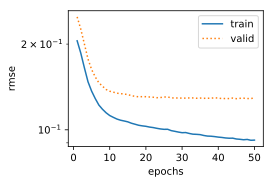

fold 0, train rmse: 0.091979, valid rmse: 0.129602
fold 1, train rmse: 0.091047, valid rmse: 0.131212
fold 2, train rmse: 0.089265, valid rmse: 0.136443
3-fold validation: avg train rmse: 0.090764, avg valid rmse: 0.132419


In [108]:
k, num_epochs, lr, weight_decay, batch_size = 3, 50, 0.00012, 0.0005, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size, 0.7, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
              % (k, train_l, valid_l))

##  Predict and Submit

In [32]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, drop_prob1,drop_prob2,mean,std):
    net = get_net(drop_prob1,drop_prob2)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = np.expm1(pd.Series(preds.reshape(1, -1)[0])*std+mean)
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

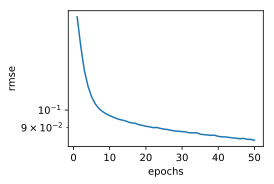

train rmse 0.083432


In [109]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,0.7,0,mean,std)

Note: I basically tried all the data preprocessing method I could think of. And tried every hyperparameters I could think of.       
The error just stops at 0.125, which is frustrating...

![](result.png)